# Homework 3

Instructions: Click **Copy to drive** at the menu bar, and enter your solutions.

Submission: Please upload your completed **solution .ipynb file and printed PDF file** to [Brightspace](https://it.stonybrook.edu/services/brightspace) by **April 27, 11:59PM EST**.



## Exercise 1: 3D Artery segmentation with MONAI

This exercise shows how to use MONAI for 3D artery segmentation.
  
Modality: CT  
Size: 100 3D volumes (60 Training + 20 Validation + 20 Testing)   


## Setup environment and check GPU status

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install "monai==1.3.0" "torch==2.0.1" "numpy==1.23.5"

In [ ]:
!python -c "import monai" || pip install -q --user "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
!nvidia-smi

2025-04-27 05:50:05.010215: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-27 05:50:05.028289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745733005.046634    1311 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745733005.052441    1311 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-27 05:50:05.074241: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Setup imports

In [ ]:
import os, glob
%matplotlib inline

from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm

from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract


import torch
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 1.3.0
Numpy version: 1.23.5
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.14.1
Pillow version: 11.1.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.51.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https

## Set dataset path

**Task:** Download the segmentation dataset [here](https://drive.google.com/drive/folders/1vUdhDu9qLvZ9XEpyl7OV9n_iPmDLGC8i?usp=sharing).

In [ ]:
import os
import glob
import zipfile
import pathlib

# Step 1: Define the directory where your 5 zip files are located
# Update this path to match your actual directory
ZIP_FILES_DIR = "/content/drive/MyDrive/hw3_data"
OUTPUT_DIR = "./segmentation_dataset"

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Step 2: Extract all zip files
zip_files = glob.glob(os.path.join(ZIP_FILES_DIR, 'segmentation_dataset-*.zip'))
print(f"Found {len(zip_files)} zip files")

for zip_file in zip_files:
    print(f"Extracting {zip_file}...")
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(OUTPUT_DIR)
    print(f"Extracted {zip_file}")

print("All files extracted to", OUTPUT_DIR)


Found 5 zip files
Extracting /content/drive/MyDrive/hw3_data/segmentation_dataset-20250416T004035Z-005.zip...
Extracted /content/drive/MyDrive/hw3_data/segmentation_dataset-20250416T004035Z-005.zip
Extracting /content/drive/MyDrive/hw3_data/segmentation_dataset-20250416T004035Z-002.zip...
Extracted /content/drive/MyDrive/hw3_data/segmentation_dataset-20250416T004035Z-002.zip
Extracting /content/drive/MyDrive/hw3_data/segmentation_dataset-20250416T004035Z-004.zip...
Extracted /content/drive/MyDrive/hw3_data/segmentation_dataset-20250416T004035Z-004.zip
Extracting /content/drive/MyDrive/hw3_data/segmentation_dataset-20250416T004035Z-003.zip...
Extracted /content/drive/MyDrive/hw3_data/segmentation_dataset-20250416T004035Z-003.zip
Extracting /content/drive/MyDrive/hw3_data/segmentation_dataset-20250416T004035Z-001.zip...
Extracted /content/drive/MyDrive/hw3_data/segmentation_dataset-20250416T004035Z-001.zip
All files extracted to ./segmentation_dataset


In [ ]:
import os
import glob

# Define the output directory where files were extracted
OUTPUT_DIR = "/content/segmentation_dataset/segmentation_dataset"

train_images = []
train_labels = []

for item in sorted(glob.glob(f"{OUTPUT_DIR}/*")):
    sid = item.split('/')[-1]
    if os.path.isdir(item):
        image_path = os.path.join(item, 'image', f"{sid}.nii.gz")
        label_path = os.path.join(item, 'label', f"{sid}.nii.gz")
        if os.path.exists(image_path) and os.path.exists(label_path):
            train_images.append(image_path)
            train_labels.append(label_path)
        else:
            print(f"Warning: Missing files for {sid}")

data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files, test_files = data_dicts[:60], data_dicts[60:80], data_dicts[80:]

print(len(train_files), len(val_files), len(test_files))

60 20 20


## Set deterministic training for reproducibility

In [ ]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.  
The image centers of negative samples must be in valid body area.
1. `EnsureTyped` converts the numpy array to PyTorch Tensor for further steps.

**Task 1.1:** Use MOMAI to rescale the intensity from [-1024,600] to [0,1], and clip outside value.

**Background:** Why clip the intensity range to [-1024,600]? Because in CT it covers from air to bone, which contain most lung anatomical structures we are interested in.

![alt text](https://firevoxel.org/docs/html/_images/view_hounsfield_scale.png "Title")

*Hint:* find a transform class in [monai.transforms](https://docs.monai.io/en/latest/transforms.html)

In [ ]:
from monai.transforms import ScaleIntensityRanged
## Complete your code here
scale_transform = ScaleIntensityRanged(
    keys=["image"],
    a_min=-1024,  # minimum input intensity (Hounsfield units)
    a_max=600,    # maximum input intensity (Hounsfield units)
    b_min=0.0,    # minimum output intensity
    b_max=1.0,    # maximum output intensity
    clip=True     # clip values outside the range
)

**Task 1.2:** Use MOMAI to randomly crop patches sized of [96,96,96] for training, in order to save GPU memory. For each image, we crop 4 patch samples. And to balance the dataset, we ramdomly sample the patch center being a foreground or background voxel with 50% probability for each case.

*Hint:* find a transform class in [monai.transforms](https://docs.monai.io/en/latest/transforms.html)

In [ ]:
from monai.transforms import RandCropByPosNegLabeld

random_crop_transform = RandCropByPosNegLabeld(
    keys=["image", "label"],    # Apply to both image and label
    label_key="label",          # Use this to identify foreground/background
    spatial_size=(96, 96, 96),  # Size of the cropped patches
    pos=1,                      # Probability of sampling from foreground
    neg=1,                      # Probability of sampling from background
    num_samples=4,              # Number of patches to extract per image
)

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        scale_transform,
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        random_crop_transform,
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        scale_transform,
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
    ]
)

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


## Check transforms in DataLoader

In [ ]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"sample image shape: {image.shape}, label shape: {label.shape}")

sample image shape: torch.Size([512, 512, 313]), label shape: torch.Size([512, 512, 313])


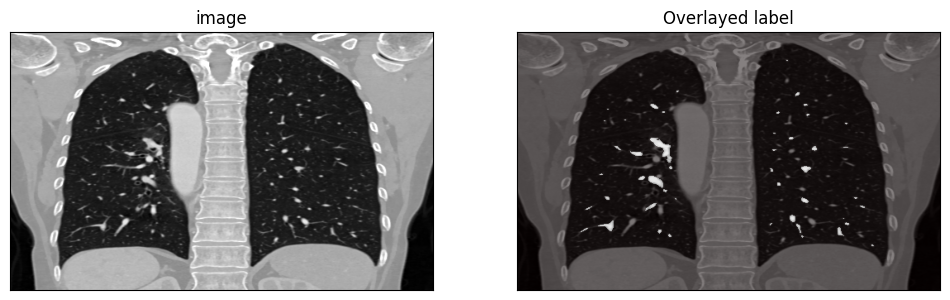

In [ ]:
# plot the slice [:, 180, :]
plt.figure("check", (12, 12))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, 180, :].transpose(0,1).flip(0), cmap="gray")
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.subplot(1, 2, 2)
plt.title("Overlayed label")

plt.imshow(image[:, 180, :].transpose(0,1).flip(0), alpha=1, cmap='gray')
plt.imshow(label[:, 180, :].transpose(0,1).flip(0), alpha=0.5, cmap='hot')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.show()

## Define CacheDataset and DataLoader for training and validation

**Task 1.3.1:** Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.   
And set `num_workers` to enable multi-threads during caching.  
**Hint:** Read more about CacheDataset [here](https://docs.monai.io/en/latest/data.html#cachedataset).

In [ ]:
## Complete your code here
train_ds = CacheDataset(
    data=train_files,
    transform=train_transforms,
    cache_rate=0.7,     # Cache all data for best performance, reduce if memory is limited
    num_workers=2       # Enable multi-threading for faster caching
)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files,
    transform=val_transforms,
    cache_rate=0.7,     # Cache all data for best performance
    num_workers=2       # Enable multi-threading for faster caching
)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

Loading dataset: 100%|██████████| 14/14 [00:46<00:00,  3.34s/it]


## Create Model, Loss, Optimizer

**Task 1.3.2:** Initialze Dice Loss and Dice metric with MONAI. Because most samples will be in background, please exclude class 0 (background) when computing the Dice metric.

In [ ]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda")

UNet_meatdata = {
    "spatial_dims": 3,
    "in_channels": 1,
    "out_channels": 2,
    "channels": (16, 32, 64, 128, 256),
    "strides": (2, 2, 2, 2),
    "num_res_units": 2,
    "norm": Norm.BATCH,
}

model = UNet(**UNet_meatdata).to(device)

## Complete your code here
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
loss_type = "DiceLoss"
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

Optimizer_metadata = {}
for ind, param_group in enumerate(optimizer.param_groups):
    optim_meta_keys = list(param_group.keys())
    Optimizer_metadata[f"param_group_{ind}"] = {
        key: value for (key, value) in param_group.items() if "params" not in key
    }

## Train the model

**Task 1.4:** Convert the label format from label index to one-hot representation.


**Task 1.5.1:** Since for training, we adopt a patch-based approach. To do inference on the full image, we can use a sliding window approach. Specifically, we can run sliding window inference and aggregate the patch-wise predictions. Complete the inference code using MONAI, and set the window size to be [160,160,160].

In [ ]:
from monai.inferers import sliding_window_inference
root_dir = './ckpt/'
os.makedirs(root_dir, exist_ok=True)
max_epochs = 90
print_interval = 15
val_interval = 1

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
## Complete your code here
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if step % print_interval == 0:
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")


    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)


    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:

        model.eval()
        with torch.no_grad():
            for index, val_data in enumerate(val_loader):
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                ## Complete your code here

                val_outputs = sliding_window_inference(inputs=val_inputs, roi_size=[160, 160, 160], sw_batch_size=1, predictor=model, overlap=0.5)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # track val metric

            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))

                best_model_log_message = f"saved new best metric model at the {epoch+1}th epoch"

                print(best_model_log_message)

            message1 = f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
            message2 = f"\nbest mean dice: {best_metric:.4f} "
            message3 = f"at epoch: {best_metric_epoch}"

            print(message1, message2, message3)

----------
epoch 1/90
15/60, train_loss: 0.6401
30/60, train_loss: 0.5975
45/60, train_loss: 0.6136
60/60, train_loss: 0.6044
epoch 1 average loss: 0.6307
saved new best metric model at the 1th epoch
current epoch: 1 current mean dice: 0.0142 
best mean dice: 0.0142  at epoch: 1
----------
epoch 2/90
15/60, train_loss: 0.6098
30/60, train_loss: 0.5745
45/60, train_loss: 0.5907
60/60, train_loss: 0.5882
epoch 2 average loss: 0.5917
saved new best metric model at the 2th epoch
current epoch: 2 current mean dice: 0.0263 
best mean dice: 0.0263  at epoch: 2
----------
epoch 3/90
15/60, train_loss: 0.5540
30/60, train_loss: 0.5937
45/60, train_loss: 0.6072
60/60, train_loss: 0.5727
epoch 3 average loss: 0.5680
saved new best metric model at the 3th epoch
current epoch: 3 current mean dice: 0.0573 
best mean dice: 0.0573  at epoch: 3
----------
epoch 4/90
15/60, train_loss: 0.5152
30/60, train_loss: 0.4953
45/60, train_loss: 0.5437
60/60, train_loss: 0.4878
epoch 4 average loss: 0.5473
curre

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.7311 at epoch: 88


If your best dice metric is around 0.75, then you are on good track.

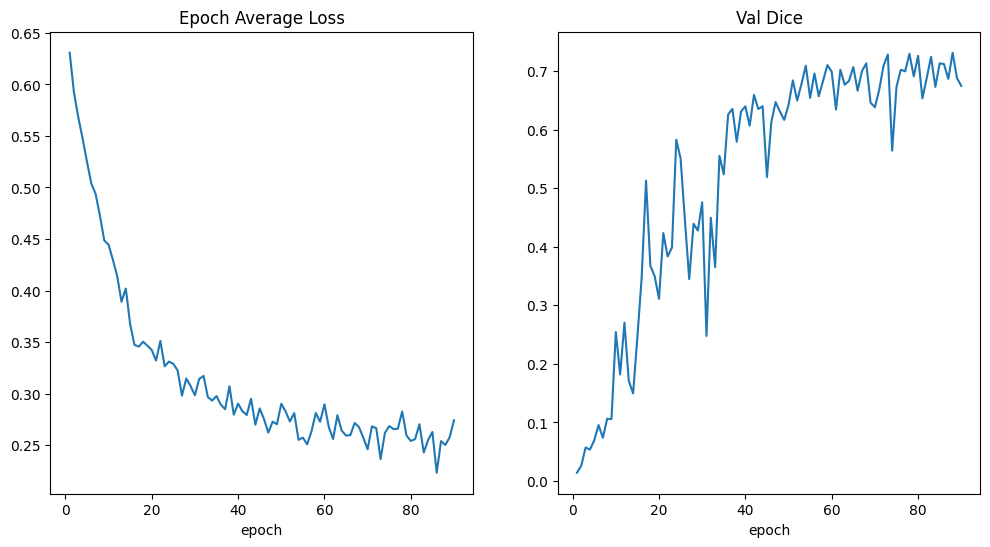

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Visualize the prediction

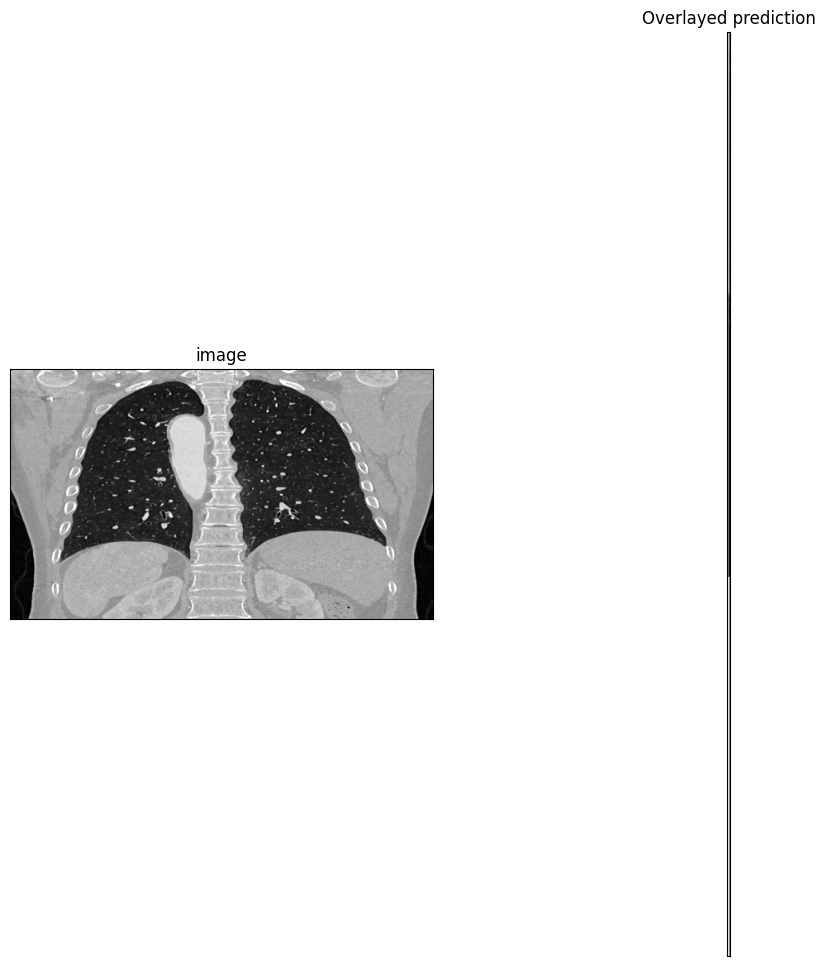

In [ ]:
# plot the slice [:, 180, :]
image = val_inputs[0,0].detach().cpu()
label = val_outputs[0][...,1].detach().cpu()

plt.figure("check", (12, 12))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, 180, :].transpose(0,1).flip(0), cmap="gray")
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.subplot(1, 2, 2)
plt.title("Overlayed prediction")
plt.imshow(image[:, 180, :].transpose(0,1).flip(0), alpha=1, cmap='gray')
plt.imshow(label[:, 180, :].transpose(0,1).flip(0), alpha=0.5, cmap='hot')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.show()

## Predict on the test set

**Task 1.5.2:** Complete the inference code below

In [ ]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        scale_transform,
        CropForegroundd(keys=["image"], source_key="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
    ]
)
## Complete your code here
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [ ]:
root_dir = './ckpt/'
save_dir = './results/'
os.makedirs(save_dir, exist_ok=True)

model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
# Complete the code below
post_label = Compose([AsDiscrete(argmax=True, to_onehot=2)])

model.eval()
with torch.no_grad():
    for index, val_data in enumerate(test_loader):
        val_inputs = val_data["image"].to(device)
        ## Complete your code here
        val_outputs = sliding_window_inference(
            inputs=val_inputs,
            roi_size=(160, 160, 160),
            sw_batch_size=4,
            predictor=model,
            overlap=0.5
        )

        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]

        val_outputs = val_outputs[0][1].detach().cpu().numpy().astype(bool)
        if index == 0:
            print(val_outputs.shape)
        np.savez_compressed(os.path.join(save_dir, str(index)+'.npz'), val_outputs)

(512, 512, 300)


**Task 1.6:** Please save your best predictions on test set in a tar.gz file and submit it through GradeScope.

In [ ]:
!tar -cf results.tar.gz results

In [ ]:
# Specify a directory that is already in sys.path
!pip install --target=/usr/local/lib/python3.11/dist-packages SimpleITK

# Import again
import SimpleITK as sitk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 42.6 MB/s eta 0:00:00


## Using Smoothing Recursive Gaussian filtering as an extra input channel

One idea to further improve our segmentation is to leverge [Objectness Measure filter](https://itk.org/Doxygen50/html/classitk_1_1ObjectnessMeasureImageFilter.html) with different scales of Gaussian smoothing filter.
Because filtered image may make vessels more visible.
In the code block below, we concatenate real image and filtered image together as input for U-Net.

**Reading material:** You can read more about vesselness [here](https://link.springer.com/chapter/10.1007/BFb0056195).

**Task 1.6:** Play with hyperparameters below until you see clear trace of vessels

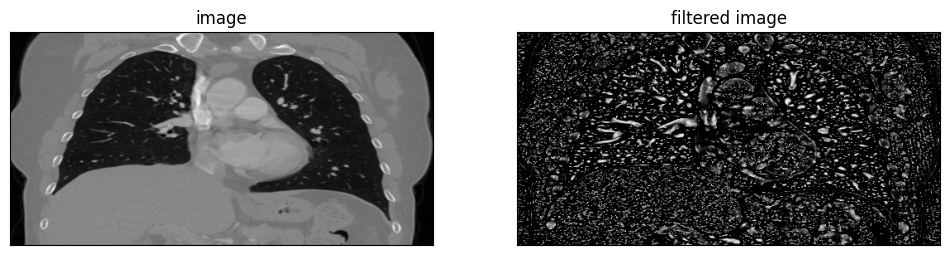

In [ ]:
input_image = sitk.ReadImage(train_files[0]['image'], sitk.sitkFloat32)

# Set the parameters for the objectness measure

sigmas = [0.5, 1.0, 1.5, 2.0, 2.5]
images = [
    sitk.ObjectnessMeasure(
        sitk.SmoothingRecursiveGaussian(input_image, s),
        alpha=0.5,
        beta=0.5,
        gamma=5.0,
        scaleObjectnessMeasure=False,
        objectDimension=1,
        brightObject=True,
    )
    for s in sigmas
]
result = sitk.MaximumProjection(sitk.JoinSeries(images), projectionDimension=images[0].GetDimension())

image = sitk.GetArrayFromImage(input_image)
label = sitk.GetArrayFromImage(result)[0]

plt.figure("check", (12, 12))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(np.flip(image[:, 250, :], 0), cmap="gray")
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.subplot(1, 2, 2)
plt.title("filtered image")
plt.imshow(np.flip(label[:, 250, :], 0), cmap="gray")
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.show()

When you see the filtering is working, run the filtering on the full dataset.

In [ ]:
filter_img_dir = './filter_img/'
os.makedirs(filter_img_dir, exist_ok=True)

for idx, item in enumerate(sorted(glob.glob("/content/segmentation_dataset/segmentation_dataset/*"))[:80]):
    sid = item.split('/')[-1]
    image_path = item+'/image/'+sid+'.nii.gz'

    input_image = sitk.ReadImage(image_path, sitk.sitkFloat32)

    # Set the parameters for the objectness measure according to specific input,
    images = [
        sitk.ObjectnessMeasure(
            sitk.SmoothingRecursiveGaussian(input_image, s),
            alpha=0.5,
            beta=0.5,
            gamma=5.0,
            scaleObjectnessMeasure=False,
            objectDimension=1,
            brightObject=True,
        )
        for s in sigmas
    ]
    result = sitk.MaximumProjection(sitk.JoinSeries(images), projectionDimension=images[0].GetDimension())
    sitk.WriteImage(result, os.path.join(filter_img_dir, sid+'.nii.gz'))


In [ ]:
import glob
import os

filter_img_dir = '/content/drive/MyDrive/filter_img'

train_images = []
train_labels = []
train_filtered_img = []

for item in sorted(glob.glob("/content/segmentation_dataset/segmentation_dataset/*")):
    sid = os.path.basename(item)  # Better than splitting manually
    train_images.append(os.path.join(item, 'image', f"{sid}.nii.gz"))
    train_labels.append(os.path.join(item, 'label', f"{sid}.nii.gz"))
    train_filtered_img.append(os.path.join(filter_img_dir, f"{sid}.nii.gz"))  # Fixed path

data_dicts = [
    {
        "image": image_name,
        "label": label_name,
        "filtered_img": filtered_img_name
    }
    for image_name, label_name, filtered_img_name in zip(train_images, train_labels, train_filtered_img)
]

# Split into train/val/test (60/20/20)
train_files, val_files, test_files = data_dicts[:60], data_dicts[60:80], data_dicts[80:]

**Task 1.7:** Complete the random crop transform similar to Task 1.2. But in this time, you will need to corp filtered image as well.

In [ ]:
## Complete your code here
from monai.transforms import RandCropByPosNegLabeld
random_crop_transform = RandCropByPosNegLabeld(
    keys=["image", "filtered_img", "label"],
    label_key="label",
    spatial_size=[96, 96, 96],
    pos=1,
    neg=1,
    num_samples=4,
)

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "filtered_img", "label"]),
        EnsureChannelFirstd(keys=["image", "filtered_img", "label"]),
        scale_transform,
        CropForegroundd(keys=["image", "filtered_img", "label"], source_key="image"),
        Orientationd(keys=["image", "filtered_img", "label"], axcodes="RAS"),
        random_crop_transform,
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "filtered_img", "label"]),
        EnsureChannelFirstd(keys=["image", "filtered_img", "label"]),
        scale_transform,
        CropForegroundd(keys=["image", "filtered_img", "label"], source_key="image"),
        Orientationd(keys=["image", "filtered_img", "label"], axcodes="RAS"),
        random_crop_transform
    ]
)

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [ ]:
import os

# Define the directory path
directory_path = '/content/drive/MyDrive/filter_img'

# List all .nii.gz files (not folders)
nii_files = [f for f in os.listdir(directory_path) if f.endswith('.nii.gz')]

print("NIfTI files in the directory:")
print(nii_files)

NIfTI files in the directory:
['PA000005.nii.gz', 'PA000016.nii.gz', 'PA000024.nii.gz', 'PA000026.nii.gz', 'PA000027.nii.gz', 'PA000036.nii.gz', 'PA000038.nii.gz', 'PA000042.nii.gz', 'PA000046.nii.gz', 'PA000047.nii.gz', 'PA000053.nii.gz', 'PA000056.nii.gz', 'PA000060.nii.gz', 'PA000063.nii.gz', 'PA000070.nii.gz', 'PA000073.nii.gz', 'PA000074.nii.gz', 'PA000078.nii.gz', 'PA000080.nii.gz', 'PA000082.nii.gz', 'PA000090.nii.gz', 'PA000091.nii.gz', 'PA000092.nii.gz', 'PA000096.nii.gz', 'PA000099.nii.gz', 'PA000100.nii.gz', 'PA000106.nii.gz', 'PA000107.nii.gz', 'PA000109.nii.gz', 'PA000115.nii.gz', 'PA000116.nii.gz', 'PA000118.nii.gz', 'PA000120.nii.gz', 'PA000121.nii.gz', 'PA000124.nii.gz', 'PA000125.nii.gz', 'PA000127.nii.gz', 'PA000128.nii.gz', 'PA000132.nii.gz', 'PA000133.nii.gz', 'PA000137.nii.gz', 'PA000138.nii.gz', 'PA000144.nii.gz', 'PA000147.nii.gz', 'PA000148.nii.gz', 'PA000150.nii.gz', 'PA000157.nii.gz', 'PA000162.nii.gz', 'PA000168.nii.gz', 'PA000169.nii.gz', 'PA000174.nii.gz', 

In [ ]:
# Complete the code below
train_ds = CacheDataset(
    data=train_files,
    transform=train_transforms,
    cache_rate=0.7,
    num_workers=4
)

train_loader = DataLoader(train_ds, batch_size=1  , shuffle=True, num_workers=2)

val_ds = CacheDataset(
    data=val_files,
    transform=val_transforms,
    cache_rate=0.8,
    num_workers=2
)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=2 )

Loading dataset: 100%|██████████| 16/16 [01:36<00:00,  6.02s/it]


In [ ]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

In [ ]:
# Complete the code below
UNet_meatdata = {
    "spatial_dims": 3,
    "in_channels": 2,
    "out_channels": 2,
    "channels": (16, 32, 64, 128, 256),
    "strides": (2, 2, 2, 2),
    "num_res_units": 2,
    "norm": Norm.BATCH,
}

device = torch.device("cuda")
model = UNet(**UNet_meatdata).to(device)

optimizer = torch.optim.Adam(model.parameters(), 1e-4)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
loss_type = "DiceLoss"
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

Optimizer_metadata = {}
for ind, param_group in enumerate(optimizer.param_groups):
    optim_meta_keys = list(param_group.keys())
    Optimizer_metadata[f"param_group_{ind}"] = {
        key: value for (key, value) in param_group.items() if "params" not in key
    }

In [ ]:
  from monai.inferers import sliding_window_inference

  root_dir = './ckpt_filtered/'
  os.makedirs(root_dir, exist_ok=True)

  max_epochs = 45
  print_interval = 15
  val_interval = 1

  best_metric = -1
  best_metric_epoch = -1
  epoch_loss_values = []
  metric_values = []
  post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])


  post_label = Compose([AsDiscrete(to_onehot=2)])

  for epoch in range(max_epochs):
      print("-" * 10)
      print(f"epoch {epoch + 1}/{max_epochs}")
      model.train()
      epoch_loss = 0
      step = 0
      for batch_data in train_loader:
          step += 1
          inputs, inputs_filered, labels = (
              batch_data["image"].to(device),
              batch_data["filtered_img"].to(device),
              batch_data["label"].to(device),
          )
          optimizer.zero_grad()
          outputs = model(torch.cat([inputs, inputs_filered], dim=1))
          loss = loss_function(outputs, labels)
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
          if step % print_interval == 0:
              print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")


      epoch_loss /= step
      epoch_loss_values.append(epoch_loss)


      print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

      if (epoch + 1) % val_interval == 0:

          model.eval()
          with torch.no_grad():
              for index, val_data in enumerate(val_loader):
                  val_inputs, val_inputs_filtered, val_labels = (
                      val_data["image"].to(device),
                      val_data["filtered_img"].to(device),
                      val_data["label"].to(device),
                  )
                  #val_outputs =  model(torch.cat([val_inputs, val_inputs_filtered], dim=1))
                  val_outputs = sliding_window_inference(inputs=torch.cat([val_inputs, val_inputs_filtered], dim=1), roi_size=[160, 160, 160], sw_batch_size=1, predictor=model, overlap=0.5)

                  val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                  val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                  # compute metric for current iteration
                  dice_metric(y_pred=val_outputs, y=val_labels)

              # aggregate the final mean dice result
              metric = dice_metric.aggregate().item()
              # track val metric
              metric_values.append(metric)

              # reset the status for next validation round
              dice_metric.reset()

              metric_values.append(metric)
              if metric > best_metric:
                  best_metric = metric
                  best_metric_epoch = epoch + 1
                  torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))

                  best_model_log_message = f"saved new best metric model at the {epoch+1}th epoch"

                  print(best_model_log_message)

              message1 = f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
              message2 = f"\nbest mean dice: {best_metric:.4f} "
              message3 = f"at epoch: {best_metric_epoch}"

              print(message1, message2, message3)

----------
epoch 1/45
15/60, train_loss: 0.6534
30/60, train_loss: 0.6032
45/60, train_loss: 0.5708
60/60, train_loss: 0.5625
epoch 1 average loss: 0.6091
saved new best metric model at the 1th epoch
current epoch: 1 current mean dice: 0.2003 
best mean dice: 0.2003  at epoch: 1
----------
epoch 2/45
15/60, train_loss: 0.5866
30/60, train_loss: 0.5711
45/60, train_loss: 0.5891
60/60, train_loss: 0.5658
epoch 2 average loss: 0.5750
saved new best metric model at the 2th epoch
current epoch: 2 current mean dice: 0.2342 
best mean dice: 0.2342  at epoch: 2
----------
epoch 3/45
15/60, train_loss: 0.6084
30/60, train_loss: 0.5555
45/60, train_loss: 0.5580
60/60, train_loss: 0.5286
epoch 3 average loss: 0.5536
current epoch: 3 current mean dice: 0.2094 
best mean dice: 0.2342  at epoch: 2
----------
epoch 4/45
15/60, train_loss: 0.4808
30/60, train_loss: 0.5661
45/60, train_loss: 0.5250
60/60, train_loss: 0.5794
epoch 4 average loss: 0.5403
current epoch: 4 current mean dice: 0.1757 
best m

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.5911 at epoch: 38


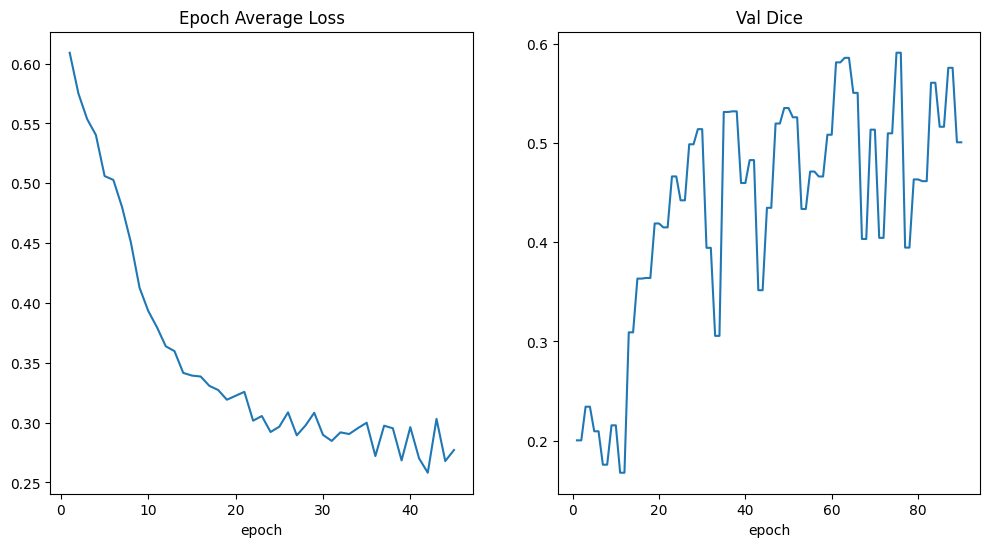

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

Because the filtering process is sensitive to the hyperparameter chosen. If your initial validation Dice is equal or less then the baseline (0.7536), that's still fine, there won't be penality.

Please tune the parameter in the Objectness Measure filter to achieve better performance on validation set. If your performance outperforms base methods, we will give you bonus.

## due to the time constraint i checked only for the 45 epochs